# Importing Libraries

In [1]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
%run "Stock Data.ipynb".ipynb
%run "Binance API.ipynb".ipynb
%run "RiskMetrics.ipynb".ipynb

# Importing Data

## Tickers

In [3]:
binance_api_key='E90xR7UnO2oeP3lrgC50zkqUuAqyyXs4uSlAGcqIVO9n90ELrFI4gfVI2HGGxxCj'
binance_api_secret='Inls2xYl9FqPi0zlIrucfxG81drx7w6Pv6SzYFxMNoAcwDjlCKug7zUM9zB3lF9h'
Binance=BinanceAPI(binance_api_key,binance_api_secret)

In [4]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [5]:
start_date=datetime.datetime(2023,12,1)
enddate=start_date+datetime.timedelta(500)

In [6]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:75].to_list()
holding=Binance.get_inventory()
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
tickers=sorted(list(set(tickers+holding_tickers)))

In [7]:
data1=Binance.get_price(tickers,start_date)
data2=Binance.get_price(tickers,enddate)
data=data1.combine_first(data2)
data.index=pd.to_datetime(data.index)
#data=data.dropna(axis=1)
n=len(data.columns)
data=data.sort_index()

In [8]:
inventory_weights=(holding['Weights in %'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')

1.0

In [9]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [10]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

### Positions

In [11]:
position=pd.read_excel('Positions.xlsx',index_col=0)

In [12]:
positions=Binance.get_positions_history(enddate=datetime.datetime.today()-datetime.timedelta(1),
                                        startdate=datetime.datetime(2024,5,5))
positions=positions.iloc[:-1]

2024-05-05 00:00:00
2024-06-04 00:00:00
2024-07-04 00:00:00
LDUMAUSDT not retrieved
LDUMAUSDT


In [13]:
positions=positions.sort_index()

In [14]:
positions.index=pd.to_datetime(positions.index)

In [15]:
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

In [16]:
positions.to_excel('Positions.xlsx')

In [17]:
positions['Total']=positions.sum(axis=1)
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total']).fillna(0)

In [18]:
binance_data=Binance.get_price(positions.columns,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()

binance_data=np.log(1+binance_data.pct_change())


LDUMAUSDT not retrieved
Total not retrieved


In [19]:
historical_ptf=pd.DataFrame()

In [20]:
for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

<AxesSubplot:>

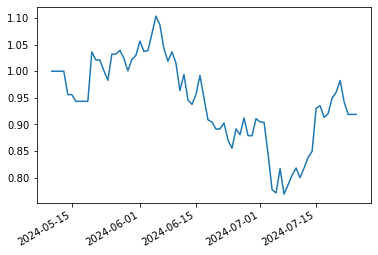

In [21]:
historical_ptf.dropna(axis = 0, how = 'all', inplace = True)
(1+historical_ptf['Historical Portfolio']).cumprod().plot()

### Ex ante data

In [22]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

In [23]:
historical_risk=RiskAnalysis(returns_to_use)
current_risk=RiskAnalysis(ex_ante_perf_to_use)
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [24]:
returns_to_use.columns

Index(['1000SATSUSDT', 'AAVEUSDT', 'ADAUSDT', 'ALGOUSDT', 'APTUSDT', 'ARBUSDT',
       'ARUSDT', 'ATOMUSDT', 'AVAXUSDT', 'AXSUSDT', 'BCHUSDT', 'BNBUSDT',
       'BONKUSDT', 'BTCUSDT', 'DOGEUSDT', 'DOTUSDT', 'DYDXUSDT', 'EGLDUSDT',
       'ENSUSDT', 'EOSUSDT', 'ETCUSDT', 'ETHUSDT', 'FDUSDUSDT', 'FETUSDT',
       'FILUSDT', 'FLOKIUSDT', 'FLOWUSDT', 'FTMUSDT', 'GALAUSDT', 'GRTUSDT',
       'HBARUSDT', 'ICPUSDT', 'IMXUSDT', 'INJUSDT', 'JASMYUSDT', 'LDOUSDT',
       'LINKUSDT', 'LTCUSDT', 'MATICUSDT', 'MKRUSDT', 'NEARUSDT', 'NEOUSDT',
       'NEXOUSDT', 'OMUSDT', 'OPUSDT', 'ORDIUSDT', 'PEPEUSDT', 'QNTUSDT',
       'RUNEUSDT', 'SANDUSDT', 'SEIUSDT', 'SHIBUSDT', 'SOLUSDT', 'STXUSDT',
       'SUIUSDT', 'THETAUSDT', 'TIAUSDT', 'TRXUSDT', 'UNIUSDT', 'USDCUSDT',
       'VETUSDT', 'WBETHUSDT', 'WBTCUSDT', 'XECUSDT', 'XLMUSDT', 'XRPUSDT',
       'XTZUSDT'],
      dtype='object')

In [25]:
limit=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0]

## Optimal Portfolio

In [26]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit[0]]-0.40}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory

,Weights
BTCUSDT,0.400000
OMUSDT,0.390181
PEPEUSDT,0.091962
BNBUSDT,0.064390
JASMYUSDT,0.053467


In [27]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

In [28]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit[0]]-0.40}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current

,Weights
OMUSDT,0.598271
BTCUSDT,0.400000
JASMYUSDT,0.001729


## Real Portfolio vs Optimal

In [29]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison['Spread']=current_holding_comparison['Weights in %']-current_holding_comparison['Weights']
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison

,Price in USDT,Weights in %,Weights,Spread
BTCUSDT,695.088138,3.357559e-01,0.400000,-0.064244
JASMYUSDT,333.127163,1.609140e-01,0.001729,0.159185
SOLUSDT,249.623089,1.205781e-01,0.000000,0.000000
OMUSDT,245.431483,1.185534e-01,0.598271,-0.479718
ETHUSDT,219.324742,1.059428e-01,0.000000,0.000000
BBUSDT,128.343172,6.199499e-02,0.000000,0.000000
MKRUSDT,120.275897,5.809817e-02,0.000000,0.000000
BNBUSDT,57.786228,2.791311e-02,0.000000,0.000000
TRXUSDT,21.218557,1.024943e-02,0.000000,0.000000
PEPEUSDT,0.000003,1.341308e-09,0.000000,0.000000


In [30]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,inventory],axis=1)
historical_comparison['Spread']=historical_comparison['Weights in %']-historical_comparison['Weights']
historical_comparison=historical_comparison.fillna(0)
historical_comparison

,Price in USDT,Weights in %,Weights,Spread
BTCUSDT,695.088138,3.357559e-01,0.400000,-0.064244
JASMYUSDT,333.127163,1.609140e-01,0.053467,0.107447
SOLUSDT,249.623089,1.205781e-01,0.000000,0.000000
OMUSDT,245.431483,1.185534e-01,0.390181,-0.271628
ETHUSDT,219.324742,1.059428e-01,0.000000,0.000000
BBUSDT,128.343172,6.199499e-02,0.000000,0.000000
MKRUSDT,120.275897,5.809817e-02,0.000000,0.000000
BNBUSDT,57.786228,2.791311e-02,0.064390,-0.036477
TRXUSDT,21.218557,1.024943e-02,0.000000,0.000000
PEPEUSDT,0.000003,1.341308e-09,0.091962,-0.091962


## Risk Reward Analysis

In [31]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [32]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf

<AxesSubplot:>

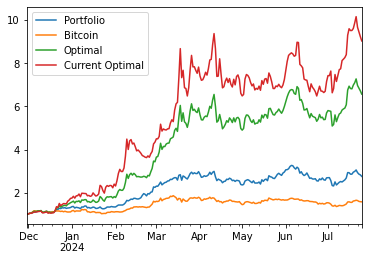

In [70]:
(1+portfolio_perf).cumprod().plot()

In [34]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

<AxesSubplot:>

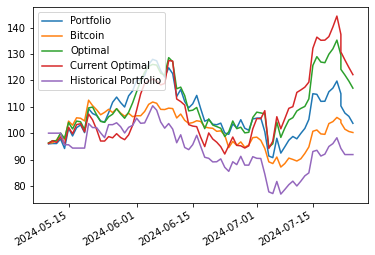

In [35]:
((1+current_perf).cumprod()*100).plot()

In [36]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)

vol

Portfolio    0.69472
dtype: float64

In [37]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)

vol

Portfolio    0.552633
dtype: float64

In [38]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.513137
Bitcoin            0.436277
Optimal            0.696124
Current Optimal    0.884853
dtype: float64

In [39]:
perf_analysis=pd.concat([historical_risk.perf_contrib_pct(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis

,Performance Contribution in %,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BNBUSDT,0.008861,0.014493,0.020627,0.002172,0.018455
BTCUSDT,0.026104,0.064021,0.170843,0.062845,0.107998
JASMYUSDT,0.011782,0.016009,0.036017,0.007789,0.028228
OMUSDT,0.915787,0.862484,0.680077,0.579007,0.101070
PEPEUSDT,0.037466,0.042993,0.092437,0.032650,0.059786


In [40]:
perf_analysis=pd.concat([current_risk.perf_contrib_pct(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis

,Performance Contribution in %,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BTCUSDT,0.067192,0.317699,0.195021,0.050307,0.144714
JASMYUSDT,0.411286,0.176186,0.263641,0.101175,0.162467
SOLUSDT,0.124338,0.119200,0.123789,0.022037,0.101752
OMUSDT,0.752067,0.163313,0.137388,0.040008,0.097380
ETHUSDT,0.048809,0.104687,0.081233,0.010251,0.070982
BBUSDT,-0.333654,0.031784,0.124562,0.032728,0.091834
MKRUSDT,-0.053238,0.051490,0.053476,0.005551,0.047925
BNBUSDT,-0.026372,0.025762,0.019404,0.000609,0.018796
TRXUSDT,0.009573,0.009878,0.001486,0.000017,0.001470


## Value At Risk

### Historical

In [41]:
var,cvar=historical_risk.historical_var(opt_weights)
(var,cvar)

(-0.056427072023966574, -0.08414503155250953)

In [42]:
var,cvar=current_risk.historical_var(current_weights)
(var,cvar)

(-0.04619598279986104, -0.06717035661189749)

### Parametric

In [43]:
var,cvar=historical_risk.parametric_var(opt_weights)

(var,cvar)

(-0.07212964061144192, -0.09245025652273359)

In [44]:
var,cvar=current_risk.parametric_var(current_weights)

(var,cvar)

(-0.05726164614620344, -0.07339359839109948)

### Multivariate

In [45]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.06344839464900322, -0.08189085085545392)

In [46]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.05441340115837596, -0.06987003365089009)

### Copulas

In [47]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06361849744550419, -0.08037433645258961)

In [48]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.056176003851849315, -0.07039721854627502)

In [49]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06263162516503254, -0.08209344709242229)

In [50]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05674185878429012, -0.07361481332831533)

### Monte Carlo

In [51]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [52]:
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.0745029458666365, -0.0923685390329068)

In [53]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.058139112586094395, -0.07355917293448126)

### VaR Violation

In [54]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2024-01-14,-0.058651,-0.096210,-0.085421,-0.025603
2024-01-15,-0.058651,-0.096233,-0.083010,0.017710
2024-01-16,-0.058651,-0.096666,-0.081320,0.051299
2024-01-17,-0.058651,-0.098707,-0.083980,-0.032182
2024-01-18,-0.058651,-0.100790,-0.086274,-0.034936
...,...,...,...,...
2024-07-21,-0.099889,-0.094565,-0.085781,0.025075
2024-07-22,-0.099889,-0.096892,-0.085460,-0.041826
2024-07-23,-0.099889,-0.096039,-0.087201,-0.017248
2024-07-24,-0.099889,-0.096698,-0.091121,-0.018987


In [55]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-28,-0.035880,-0.091246,-0.084777,-0.018377
2024-05-29,-0.029064,-0.087811,-0.076541,-0.015013
2024-05-30,-0.029064,-0.077457,-0.067656,0.038503
2024-05-31,-0.027056,-0.073734,-0.062725,0.016586
2024-06-01,-0.027056,-0.074033,-0.062865,0.034113
2024-06-02,-0.027056,-0.074216,-0.064038,0.002626
2024-06-03,-0.019582,-0.069838,-0.057485,0.013130
2024-06-04,-0.019582,-0.051742,-0.043819,0.033869
2024-06-05,-0.019582,-0.048921,-0.037982,0.015533
2024-06-06,-0.019582,-0.048621,-0.037461,-0.004466


<AxesSubplot:>

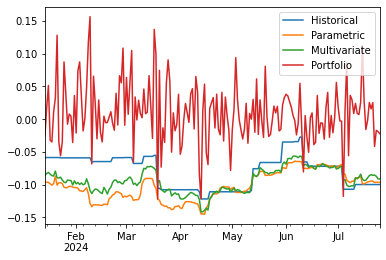

In [56]:
var_data.plot()

<AxesSubplot:>

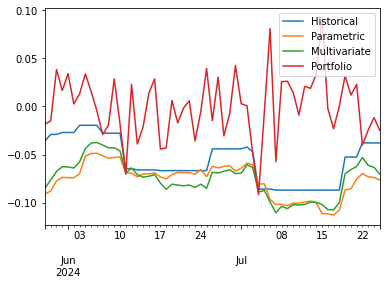

In [57]:
current_var_data.plot()

In [58]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.020619,0.010309,0.015464
Kupiec Stat,4.487847,9.4014,6.59959
P-value,0.034137,0.002168,0.0102


In [59]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.084746,0.033898,0.033898
Kupiec Stat,1.252236,0.36138,0.36138
P-value,0.263126,0.547741,0.547741


## Principal Component Analysis

In [60]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.75883641, 0.07367268, 0.06098535, 0.05606072, 0.05044485])

In [61]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.61573752, 0.16779101, 0.095437  , 0.07783768, 0.04319679])

In [62]:
"""faire contrib a la var de chaques modeles"""

'faire contrib a la var de chaques modeles'

In [63]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))

<AxesSubplot:>

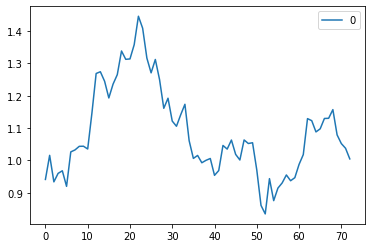

In [64]:
x=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)))
x=x.dropna()
(1+x).cumprod().plot()

<AxesSubplot:>

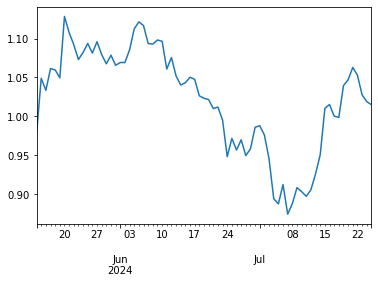

In [65]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()

In [66]:
multivariate_distrib=pd.DataFrame(historical_risk.multivariate_distribution(),columns=historical_risk.returns.columns)

multivariate_distrib=multivariate_distrib*opt_weights
multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[opt_weights>0]]

multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]['Portfolio']
multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]/multivariate_var

BNBUSDT      0.020279
BTCUSDT      0.018881
JASMYUSDT    0.025498
OMUSDT       1.005276
PEPEUSDT    -0.069933
Portfolio    1.000000
Name: 1388, dtype: float64

In [67]:
gaussian_copula_distrib=pd.DataFrame(historical_risk.gaussian_copula(),columns=historical_risk.returns.columns)

gaussian_copula_distrib=gaussian_copula_distrib*opt_weights
gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[opt_weights>0]]

gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]['Portfolio']
gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]/gaussian_var

BNBUSDT     -0.015938
BTCUSDT      0.012624
JASMYUSDT   -0.029879
OMUSDT       0.922391
PEPEUSDT     0.110802
Portfolio    1.000000
Name: 8145, dtype: float64

In [68]:
t_copula_distrib=pd.DataFrame(historical_risk.t_copula(),columns=historical_risk.returns.columns)
t_copula_distrib=t_copula_distrib*opt_weights
t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[opt_weights>0]]
t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]['Portfolio']
t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]/t_copula_var

BNBUSDT      0.014108
BTCUSDT      0.139991
JASMYUSDT    0.048332
OMUSDT       0.787680
PEPEUSDT     0.009888
Portfolio    1.000000
Name: 3197, dtype: float64

In [69]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
monte_carlo_distrib=monte_carlo[1].fillna(0)*opt_weights
monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[opt_weights>0]]
monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]/monte_carlo_var

BNBUSDT      0.008037
BTCUSDT      0.179351
JASMYUSDT    0.043079
OMUSDT       0.670068
PEPEUSDT     0.099465
Portfolio    1.000000
Name: 7431, dtype: float64